In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import keras

import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from gensim.models import Word2Vec

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
plt.style.use("fivethirtyeight")

In [4]:
df_train = pd.read_csv("C:\\Users\\boydd\\Downloads\\train (5).csv")
df_test = pd.read_csv("C:\\Users\\boydd\\Downloads\\test (5).csv")

<BarContainer object of 2 artists>

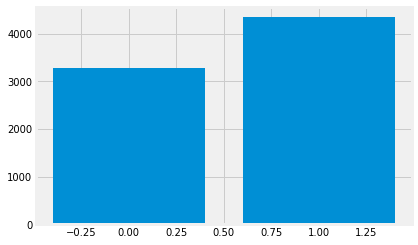

In [204]:
counts = df_train['target'].value_counts()
plt.bar(x=df_train['target'].unique(), height=counts)

In [7]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
# Word counts
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==1]
     ['word_count'].mean())
print(df_train[df_train['target']==0]
     ['word_count'].mean())

15.167532864567411
14.704744357438969


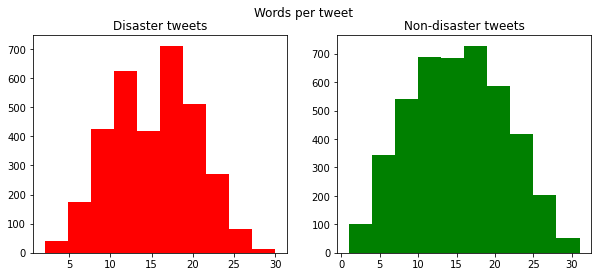

In [9]:
# plot in histogram
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [6]:
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['char_count'].mean()) #Non-Disaster tweets

108.11342097217977
95.70681713496084


In [7]:
# Text preprocessing
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# Remove stopwords
def stopword(string):
    a = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# Lemmatization
wl = WordNetLemmatizer()
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

In [12]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,id,keyword,location,text,target,word_count,char_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,get sent photo ruby alaska smoke wildfires pou...


In [13]:
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x))
df_test.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee across street...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse light spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [14]:
test_text = df_test['clean_text']

In [15]:
# Vectorize the text
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"], df_train['target'], test_size=0.2)
# Word2Vec
X_train_tok = [nltk.word_tokenize(i) for i in X_train]
X_test_tok = [nltk.word_tokenize(i) for i in X_test]

In [16]:
# Bag of words TD-IDF
tfidf = TfidfVectorizer(use_idf=True)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [17]:
test_text_vec = tfidf.transform(test_text)

In [18]:
# Word2Vec
#building Word2Vec model
model1 = Word2Vec(df_train['clean_text'], min_count=1,
                 vector_size=100, window=5)
# Skip Gram model
model2 = Word2Vec(df_train['clean_text'], min_count=1,
                 vector_size=100, window=5, sg=1)

In [19]:
w2v_model = Word2Vec(X_train_tok, vector_size=100,
                    window=5, min_count=2)

In [20]:
# Naive Bayes with TF-IDF data
nb_tf = MultinomialNB()
nb_tf.fit(X_train_vec, y_train)
nb_pred = nb_tf.predict(X_test_vec)
print(confusion_matrix(y_test, nb_pred))

[[768  84]
 [239 432]]


In [21]:
print(accuracy_score(y_test, nb_pred))

0.7879185817465528


In [56]:
final_test_pred = nb_tf.predict(test_text_vec)

In [59]:
submission1 = pd.DataFrame()
submission1['id'] = df_test['id']
submission1['target'] = final_test_pred
submission1.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [60]:
submission1.to_csv("C:\\Users\\boydd\\Downloads\\NLP_Submission1.csv", index=False)

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

In [50]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_vec, y_train)
gb_pred = gbc.predict(X_test_vec)
print(confusion_matrix(y_test, gb_pred))
print(accuracy_score(y_test, gb_pred))

[[828  62]
 [309 324]]
0.7564018384766907


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [52]:
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
rf_pred = rf.predict(X_test_vec)
print(confusion_matrix(y_test, rf_pred))
print(accuracy_score(y_test, rf_pred))

[[806  84]
 [254 379]]
0.778069599474721


In [79]:
# RF hyperparameter tuning
param_grid = {
    'n_estimators': [15, 25, 50],
    'max_features': ['sqrt'],
    'max_depth': [4,6,None],
    'max_leaf_nodes': [6,9,12]
}

In [80]:
grid_search_rf = GridSearchCV(RandomForestClassifier(),
                             param_grid=param_grid)
grid_search_rf.fit(X_train_vec, y_train)
print(grid_search_rf.best_params_)

{'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 12, 'n_estimators': 50}


In [93]:
from sklearn.neural_network import MLPClassifier

In [94]:
mlp = MLPClassifier()
mlp.fit(X_train_vec, y_train)
mlp_pred = mlp.predict(X_test_vec)
print(confusion_matrix(y_test, mlp_pred))
print(accuracy_score(y_test, mlp_pred))

[[684 206]
 [185 448]]
0.7432698621142482


In [66]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [16]:
# Pass the test data through this dataset to get
# baseline accuracy score

In [8]:
# Add hyperparameter tuning and more complex model
# with keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from keras.layers import Flatten, Embedding

In [9]:
# For keras model, the input_dim is the input dimension
# or X_train.shape[1]
from keras.preprocessing.text import Tokenizer

In [20]:
import tensorflow as tf

In [51]:
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, GlobalMaxPool1D

In [55]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

In [56]:
tweets = df_train['text']
labels = df_train['target']

In [125]:
VOC_SIZE = 10000
onehot_vector = [one_hot(words, VOC_SIZE) for words in tweets]
onehot_vector[110:120]

[[8164, 7920, 1164, 8756, 2906, 9610, 1898, 731, 9139, 2844, 6814],
 [9763, 3934, 8370, 1609, 4037, 4307, 4659, 8220, 5823, 3365, 2521],
 [3365,
  3624,
  2844,
  7319,
  59,
  617,
  3605,
  1512,
  94,
  1676,
  8963,
  5120,
  5313,
  94,
  8963,
  5120,
  588,
  9205],
 [3365, 9648, 2423, 3743, 1638],
 [3845,
  8323,
  3413,
  3365,
  6356,
  2423,
  3743,
  2715,
  7272,
  9570,
  8650,
  1897,
  4426,
  6358,
  8148,
  6356,
  2423,
  3743,
  8929],
 [3845,
  8323,
  3413,
  3365,
  6356,
  2423,
  3743,
  9951,
  7272,
  9570,
  8650,
  1897,
  4426,
  6358,
  8148,
  6356,
  2423,
  3743,
  233],
 [3845,
  8323,
  3413,
  3365,
  6356,
  2423,
  3743,
  5710,
  7272,
  9570,
  8650,
  1897,
  4426,
  6358,
  8148,
  6356,
  2423,
  3743,
  1647],
 [3769, 4443, 3668, 2265, 9610, 2635, 7457, 3365],
 [3845,
  8323,
  3413,
  3365,
  6356,
  2423,
  3743,
  5788,
  7272,
  9570,
  8650,
  1897,
  4426,
  6358,
  8148,
  6356,
  2423,
  3743,
  3673],
 [3845,
  8323,
  3413,
  3365,

In [126]:
onehot_test = [one_hot(words, VOC_SIZE) for words in df_test['text']]

In [59]:
word_length = []
for i in onehot_vector:
    word_length.append(len(i))
len(word_length)

7613

In [60]:
max(word_length)

33

In [127]:
SENTENCE_LENGTH = 15
embedded_docs = pad_sequences(onehot_vector, padding="post", maxlen=SENTENCE_LENGTH)
embedded_docs

array([[4632, 1241, 5945, ..., 1601,    0,    0],
       [6513, 4059, 9247, ...,    0,    0,    0],
       [5945,  264, 3895, ..., 5743, 5945, 8691],
       ...,
       [9271,  775,  360, ..., 3743, 8024,    0],
       [6305, 4958, 1317, ..., 9313, 5737, 7361],
       [2844, 5297, 2922, ..., 2423, 3743, 4373]])

In [128]:
embedded_test = pad_sequences(onehot_test, padding="post", maxlen=SENTENCE_LENGTH)

In [129]:
embed_train, embed_test, y_train, y_test = train_test_split(embedded_docs, labels, test_size=0.3)

In [ ]:
# Repeat with training and testing data

In [171]:
def model():
    VECTOR_FEATURES = 32
    lstm_model = Sequential()
    lstm_model.add(Embedding(VOC_SIZE,
                            VECTOR_FEATURES,
                            input_length=SENTENCE_LENGTH))
    lstm_model.add(LSTM(32, return_sequences=True))
    lstm_model.add(GlobalMaxPool1D())
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(10, activation="relu"))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(10, activation="relu"))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(1, activation="sigmoid"))
    return lstm_model

In [172]:
lstm_model = model()
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 15, 32)            320000    
                                                                 
 lstm_14 (LSTM)              (None, 15, 32)            8320      
                                                                 
 global_max_pooling1d_14 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 batch_normalization_14 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 10)              

In [173]:
history = lstm_model.fit(embed_train, y_train, validation_data=(embed_test, y_test), epochs=8, batch_size=32)

Epoch 1/8
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
167/167 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.5939WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000012FDC133C10> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set

In [174]:
lstm_pred = lstm_model(embedded_test)

In [175]:
lstm_preds = lstm_pred.numpy()

In [176]:
for i in range(len(lstm_preds)):
    if lstm_preds[i] >= 0.5:
        lstm_preds[i] = math.trunc(int(1))
    else:
        lstm_preds[i] = math.trunc(int(0))

In [158]:
lstm_pred2 = lstm_model.predict(embedded_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - 1s 4ms/step


In [99]:
pd.set_option('precision', 0)

In [177]:
submission2 = pd.DataFrame()
submission2['id'] = df_test['id']
submission2['target'] =lstm_preds
submission2.round()
submission2.head()
submission2 = submission2.astype(int)

In [178]:
submission2['target'].value_counts()

0    1966
1    1297
Name: target, dtype: int64

In [186]:
# Build CNN
def build_cnn():
    cnn = Sequential([
        Embedding(VOC_SIZE, output_dim=32, input_length = SENTENCE_LENGTH),
        layers.Conv1D(128, kernel_size=3, activation="relu"),
        layers.GlobalAveragePooling1D(),
        Dense(64, activation="relu"),
        layers.BatchNormalization(),
        Dense(32, activation="relu"),
        layers.Dropout(0.25),
        Dense(1, activation="sigmoid")
    ])
    return cnn

In [187]:
cnn_model = build_cnn()
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 15, 32)            320000    
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 128)           12416     
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_16 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_42 (Dense)            (None, 32)              

In [188]:
history_cnn = cnn_model.fit(embed_train, y_train, validation_data=(embed_test, y_test), epochs=8, batch_size=32)

Epoch 1/8
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
165/167 [============================>.] - ETA: 0s - loss: 0.5741 - accuracy: 0.7047WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000012FD2D78CA0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set

In [189]:
cnn_pred = (cnn_model.predict(embedded_test) > 0.5).reshape(-1,).astype(int)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - 0s 1ms/step


In [190]:
cnn_pred

array([0, 1, 1, ..., 1, 1, 0])

In [193]:
cnn_sub = pd.DataFrame()
cnn_sub['id'] = df_test['id']
cnn_sub['target'] = cnn_pred
cnn_sub.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [194]:
cnn_sub.to_csv("C:\\Users\\boydd\\Downloads\\NLP_Submission4.csv", index=False)